In [ ]:
import numpy as np
import scipy
import scipy.sparse
import scipy.sparse.linalg
from numpy.polynomial import chebyshev

import jax
from jax import numpy as jnp
from jax import random
from jax import grad, jvp, vjp, hessian, jacfwd, jacrev
from jax import jit, vmap
from jax.tree_util import tree_flatten

from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Tanh

from matplotlib import pyplot as plt
from time import time
from tqdm.notebook import tnrange

plt.rcParams["figure.figsize"] = (15, 6) # (w, h)
plt.rcParams.update({'font.size': 16})

## Eigenvalues of Hessian using HVPs

To get the top-k eigenvalue-eigenvector pairs, it is not necessary to calculate the Hessian explicitly.

In [ ]:
# Reference - https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html
def hvp(f, w, v):
    return jvp(grad(f), (w,), (v,))[1]

# Compute eigenpairs with a hessian-vector product function (works for symmetric matrices)
def hvp_eig(hvp_func, shape, number_values=2, tol=1E-8):
    op = scipy.sparse.linalg.LinearOperator(shape=shape, matvec=hvp_func)
    eigvals, eigvectors = scipy.sparse.linalg.eigsh(op, k=number_values, which="LA", tol=tol)
    # Return in decreasing order of eigenvalues
    return eigvals[::-1], eigvectors[:, ::-1]

# Compute eigenpairs when the (hessian) matrix is fully materialized
def full_matrix_eig(M, number_values=2, tol=1E-8):
    M = np.array(M)
    eigvals, eigvectors = scipy.sparse.linalg.eigsh(M, k=number_values, which="LA", tol=tol)
    # Return in decreasing order of eigenvalues
    return eigvals[::-1], eigvectors[:, ::-1]

### HVP runtime comparison

This will compare the runtime of computing the full hessian and then the top 2 eigenvalues, versus computing the 2 eigenvalues using hessian-vector products. The HVP version is much faster for larger dimensions.

In [ ]:
@jit
def loss_func(x):
  return jnp.sum(x ** 2)

In [ ]:
################# Code just for understanding purposes #################

key = random.PRNGKey(0)
N = 10

key, subkey = random.split(key)
weights = random.uniform(key, shape=(N,), dtype=jnp.float32)
targets = 10.0 * random.uniform(subkey, shape=(N,), dtype=jnp.float32)

def _loss_func(w):
    return loss_func(targets * w)

H_hessian = hessian(_loss_func)(weights)
print(H_hessian.shape)
# print(H_hessian)

(10, 10)


In [ ]:
################# Code just for understanding purposes #################

key = random.PRNGKey(0)
N = 10

key, subkey = random.split(key)
weights = random.uniform(key, shape=(N,), dtype=jnp.float32)
targets = 10.0 * random.uniform(subkey, shape=(N,), dtype=jnp.float32)

def _loss_func(w):
    return loss_func(targets * w)

def hvp_op(v):
    return hvp(_loss_func, weights, v)

shape = (weights.size, weights.size)

vals = hvp_op(jnp.ones(len(weights)))
H_jvp = vmap(hvp_op, in_axes=1)(jnp.eye(len(weights)))
print(H_jvp.shape)

assert jnp.allclose(H_hessian, H_jvp), 'Incorrect hessians!'
assert jnp.allclose(vals, jnp.diagonal(H_jvp)), 'Incorrect values!'

(10, 10)


In [ ]:
################# Code just for understanding purposes #################

loss = _loss_func(weights)
print("Loss:", loss)
print("Loss shape:", loss.shape)
print("Targets * Weights shape:", (targets*weights).shape)

x = (targets * weights)[0]
y = targets[0] * weights[0]

print(x, y, x == y)
jacobian_fwd = jacfwd(_loss_func)(weights)
print("Jacobian fwd shape:", jacobian_fwd.shape)

jacobian_rev = jacrev(_loss_func)(weights)
print("Jacobian rev shape:", jacobian_rev.shape)

assert jnp.allclose(jacobian_fwd, jacobian_rev), 'Incorrect jacobians!'

Loss: 75.58569
Loss shape: ()
Targets * Weights shape: (10,)
0.01577201 0.01577201 True
Jacobian fwd shape: (10,)
Jacobian rev shape: (10,)


Text(0.5, 0, 'dimension')

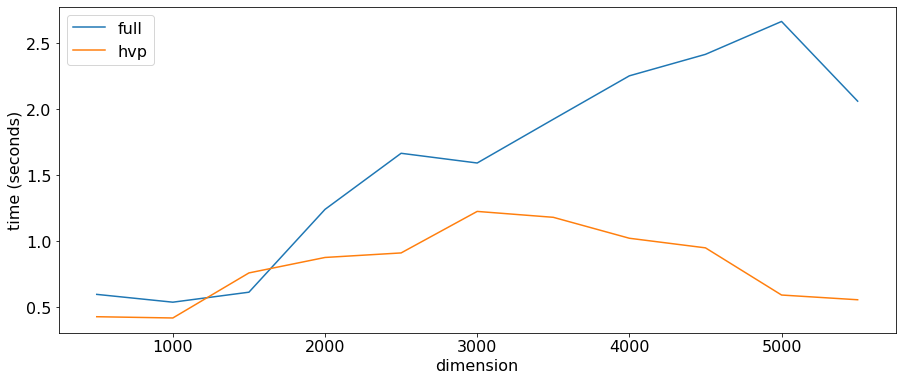

In [ ]:
eigv_tol = 1E-2

times_1 = []
times_2 = []
Ns = []

@jit
def loss_func(x):
  return jnp.sum(x ** 2)

start = 500
end = 6000
key = random.PRNGKey(0)
for N in range(start, end, 500):
  Ns.append(N)
  key, subkey = random.split(key)
  weights = random.uniform(key, shape=(N,), dtype=jnp.float32)
  targets = 10.0 * random.uniform(subkey, shape=(N,), dtype=jnp.float32)

  def _loss_func(w):
    return loss_func(targets * w)

  # Strategy 1: Construct the full hessian.
  t0 = time()
  H = hessian(_loss_func)(weights)
  x1, _ = full_matrix_eig(H, tol=eigv_tol)
  times_1.append(time() - t0)

  # Strategy 2: Hessian-vector products.
  t0 = time()

  def hvp_op(v):
    return hvp(_loss_func, weights, v)
  
  shape = (weights.size, weights.size)
  x2, _ = hvp_eig(hvp_op, shape, tol=eigv_tol)
  times_2.append(time() - t0)

from matplotlib import pyplot as plt
plt.plot(Ns, times_1, label='full')
plt.plot(Ns, times_2, label='hvp')
plt.legend()
plt.ylabel('time (seconds)')
plt.xlabel('dimension')

## Task

Appendix L.2 in the paper describes a toy regression task to fit a Chebyshev polynomial using a tanh neural network of hidden size 100.

The paper discusses using polynomials of degree 3, 4 and 5. However, here for demonstration and learning purposes, we only use a degree of 4. The dataset contains 20 points spaced uniformly on the interval [−1, 1].

### Dataset

In [ ]:
def chebyshev_degk(k, x):
    coeffs = np.array([0]*k + [1])
    return chebyshev.Chebyshev(coeffs)(x)

def dataset(k, n):
    values = np.linspace(-1.0, 1.0, n)
    targets = chebyshev_degk(k, values)
    return (values, targets)

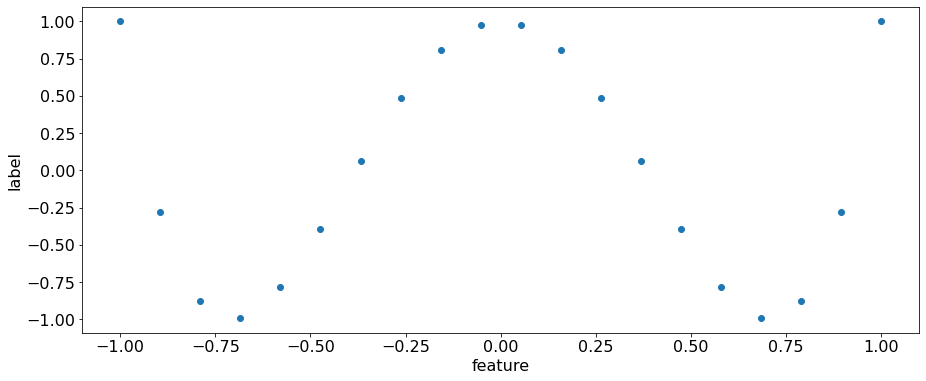

In [ ]:
n = 20
k = 4
x, y = dataset(k, n)
plt.plot(x, y, 'o')
plt.ylabel('label')
plt.xlabel('feature')
plt.show()

### Neural Network

In [ ]:
num_hidden = 100
init_random_params, predict = stax.serial(
    Dense(num_hidden),
    Tanh,
    Dense(1))

### Model training and Statistics logging

In [ ]:
@jit
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return jnp.mean((preds - targets) ** 2) 

# https://github.com/google/jax/issues/2682#issuecomment-613090890 
# (refer code below to understand how this works)
def flatten(v):
  def f(v):
    leaves, _ = tree_flatten(v)
    return jnp.concatenate([x.ravel() for x in leaves])
  out, pullback = vjp(f, v)
  return out, lambda x: pullback(x)[0]

In [ ]:
################# Code just for understanding purposes #################

def vgrad(f, x):
  y, vjp_fn = vjp(f, x)
#   print(y)
  return vjp_fn(y)[0]

def f(v):
    return jnp.concatenate([x.ravel() for x in v])

inp = [jnp.array([1.,2.,3.,4.,5.]), jnp.array([4.,5.,6.])]

print(vgrad(f, inp))

jacf = jacfwd(f)(inp)
print(jacf)
print(jacf[0].T.dot(f(inp)))
print(jacf[1].T.dot(f(inp)))

[DeviceArray([1., 2., 3., 4., 5.], dtype=float32), DeviceArray([4., 5., 6.], dtype=float32)]
[DeviceArray([[1., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0.],
             [0., 0., 1., 0., 0.],
             [0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.]], dtype=float32), DeviceArray([[0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [1., 0., 0.],
             [0., 1., 0.],
             [0., 0., 1.]], dtype=float32)]
[1. 2. 3. 4. 5.]
[4. 5. 6.]


In [ ]:
# Train using Gradient Descent
def train_gd(degree = 4,
          dataset_size = 20,
          step_size = 0.2,
          num_epochs = 2500,
          momentum_mass = 0.0,
          verbose = False,
          log_stats_every = 50,
          inspection_range = None):
    
    # Random seed for reproducibility
    rng = random.PRNGKey(42)

    # Prepare dataset
    data, labels = dataset(degree, dataset_size)
    data = data.reshape(dataset_size, 1)
    labels = labels.reshape(dataset_size, 1)

    # Neural network optimizer functions 
    # (https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html)
    opt_init_fun, opt_update_fun, get_params = optimizers.momentum(step_size, mass=momentum_mass)

    # Optimizer update function
    @jit
    def update(i, opt_curr_state, batch):
        params = get_params(opt_curr_state)
        return opt_update_fun(i, grad(loss)(params, batch), opt_curr_state)

    out_shape, init_params = init_random_params(rng, (-1, 1))
    opt_curr_state = opt_init_fun(init_params)
    loss_values = []

    stats = dict(
        sampled_epochs = [],
        top3_eigvals = [],
        weight_space_dists = [],
        iterates = [],
        weights = []
    )
    eigbasis = None
  
    for epoch in tnrange(num_epochs):
        batch = (data, labels)   # full batch gradient descent
        opt_curr_state = update(epoch, opt_curr_state, batch)
        params = get_params(opt_curr_state)
        loss_value = loss(params, batch)
        flat_params, unflatten_params = flatten(params)

        if epoch == 0:
            flat_init = flat_params

        r = inspection_range

        if (r is None and epoch % log_stats_every == 0) or \
            (r is not None and r[0] <= epoch <= r[1]):
            if verbose and epoch % 200 == 0:
                print('epoch={}, train_loss={}'.format(epoch, loss_value))

            stats['weights'].append(flat_params)

            # Loss function wrapper for which eigenpairs of the hessian are to be calculated
            def flat_loss(w):
                return loss(unflatten_params(w), batch)

            # HVP operation defined earler
            def hvp_op(v):
                return hvp(flat_loss, flat_params, v)

            # Number of parameters for one hidden layer
            n_params = num_hidden * 2 + num_hidden + 1
            # Shape of hessian is (number of parameters, number of parameters)
            shape = (n_params, n_params)
            # Calculate top-3 eigenpairs
            eigvals, eigvecs = hvp_eig(hvp_op, shape, number_values=3, tol=1E-2)

            stats['sampled_epochs'].append(epoch)
            stats['top3_eigvals'].append(eigvals[:3])

            # When sharpness first crosses threshold (2 / eta), save the top eigenbasis.
            # The paper refers to the top eigenvector at this point as q_1.
            # Take top-2 as basis for to align iterates to q_i
            if eigvals[0] >= 2.0 / step_size and eigbasis is None:
                eigbasis = eigvecs[:, :2]
            
        if eigbasis is not None:
            stats['iterates'].append(eigbasis.T @ flat_params)

        loss_values.append(loss_value)
        
        # Weight space distance from initialization
        stats['weight_space_dists'].append(jnp.linalg.norm(flat_params - flat_init))

    return loss_values, stats

In [ ]:
# Train using Gradient Flow
def train_gf(degree = 4,
          dataset_size = 20,
          num_time = 500,
          alpha = 1.0,
          verbose = False,
          log_stats_every = 10):
    
    # Random seed for reproducibility
    rng = random.PRNGKey(42)

    # Prepare dataset
    data, labels = dataset(degree, dataset_size)
    data = data.reshape(dataset_size, 1)
    labels = labels.reshape(dataset_size, 1)

    # Optimizer update function
    # Reference - https://github.com/locuslab/edge-of-stability/
    @jit
    def rk_step(curr_params, batch, step_size):
        flat_params, unflatten_params = flatten(curr_params)

        k1 = -(flatten(grad(loss)(curr_params, batch))[0])

        k2 = -(flatten(grad(loss)(unflatten_params(flat_params + (step_size / 2) * k1), batch))[0])

        k3 = -(flatten(grad(loss)(unflatten_params(flat_params + (step_size / 2) * k2), batch))[0])

        k4 = -(flatten(grad(loss)(unflatten_params(flat_params + step_size * k3), batch))[0])

        flat_params_next = flat_params + (step_size / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        new_params = unflatten_params(flat_params_next)
        return new_params

    def rk_advance_time(curr_params, rk_step_size, batch, T):
        T_remaining = T
        new_params = None

        while T_remaining > 0:
            this_step_size = min(rk_step_size, T_remaining)
            new_params = rk_step(curr_params, batch, this_step_size)
            T_remaining -= rk_step_size

        return new_params

    out_shape, init_params = init_random_params(rng, (-1, 1))
    curr_params = init_params
    loss_values = []

    stats = dict(
        sampled_steps = [],
        weights = []
    )
    eigbasis = None
    sharpness = float('inf')

    for step in tnrange(num_time):
        batch = (data, labels)   # full batch gradient descent
        loss_value = loss(curr_params, batch)
        flat_params, unflatten_params = flatten(curr_params)

        if step % log_stats_every == 0:
            if verbose and step % 200 == 0:
                print('step={}, train_loss={}'.format(step, loss_value))

            stats['weights'].append(flat_params)
            stats['sampled_steps'].append(step)

            # Loss function wrapper for which eigenpairs of the hessian are to be calculated
            def flat_loss(w):
                return loss(unflatten_params(w), batch)

            # HVP operation defined earler
            def hvp_op(v):
                return hvp(flat_loss, flat_params, v)

            # Number of parameters for one hidden layer
            n_params = num_hidden * 2 + num_hidden + 1
            # Shape of hessian is (number of parameters, number of parameters)
            shape = (n_params, n_params)
            # Calculate top-3 eigenpairs
            eigvals, eigvecs = hvp_eig(hvp_op, shape, number_values=3, tol=1E-2)
            sharpness = eigvals[0]

        loss_values.append(loss_value)
        
        rk_step_size = min(alpha / sharpness, 999)
        # print(rk_step_size)
        curr_params = rk_advance_time(curr_params, rk_step_size, batch, 1)

    return loss_values, stats

### Plotting code

In [ ]:
def make_plot(eta, losses, extras, show_time=False, 
              inspection_range=None, plot_iterates=True):
  epochs = np.arange(len(losses))
  sampled_epochs = np.array(extras['sampled_epochs'])
  xlabel = 'iteration'
  if show_time:
    epochs = epochs * eta
    sampled_epochs = sampled_epochs * eta
    xlabel = 'time'
  
  if plot_iterates:
    fig1, (ax1, ax2) = plt.subplots(1, 2)

    # Losses
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('train loss')

    sl = slice(0, len(epochs))
    if inspection_range is not None:
      sl = slice(inspection_range[0], inspection_range[1] + 1)

    ax1.plot(epochs[sl], losses[sl])
    xlim = ax1.get_xlim()

    # Weight space distance
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('weight space distance from initialization')
    ax2.plot(epochs[sl], extras['weight_space_dists'][sl])
    
    # Visualize only the projection along top eigenvector q1.
    if len(extras['iterates']) > 0:
      fig0, ax0 = plt.subplots(1, 1)
      iterates = (np.array(extras['iterates']).T)[0] # Takes projection along q1
      ax0.plot(epochs[-len(iterates):], iterates, c='orange')
      ax0.set_xlabel(xlabel)
      ax0.set_xlim(xlim)
      ax0.set_ylabel('<q1, xt>')

  else:
    fig2, ax3 = plt.subplots(1, 1)

    # Visualize top 3 eigenvalues.
    ax3.axhline(y=2.0 / eta, ls="--")
    color_arr  = ['bo', 'go', 'yo']
    labels = ['1st largest', '2nd largest', '3rd largest']
    top3_eigs = np.array(extras['top3_eigvals']).T
    for (i, eigs) in enumerate(top3_eigs):
      ax3.plot(sampled_epochs, eigs, color_arr[i], label=labels[i])

    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('sharpness')
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    plt.legend()

In [ ]:
def plot_distance_from_gradient_flow(all_weights_gd, all_weights_gf, all_gf_freq, all_etas=None):
    fig0, ax0 = plt.subplots(1, 1)
    
    for i in range(len(all_weights_gd)):
        weights_gd = all_weights_gd[i]
        weights_gf = all_weights_gf[i]
        gf_freq = all_gf_freq[i]
        
        l2 = []
        for j in range(len(weights_gd)):
            l2.append(jnp.linalg.norm(weights_gd[j] - weights_gf[j]))

        xs = list(range(0, len(weights_gd) * gf_freq, gf_freq))

        if all_etas is not None:
            ax0.plot(xs, l2, label="Eta = 2/" + str(int(2/all_etas[i])))
        else:
            ax0.plot(xs, l2)
        ax0.set_xlabel('time')
        ax0.set_ylabel('distance from gradient flow')
        if all_etas is not None:
            ax0.legend()

In [ ]:
def make_etas_plot(etas, all_losses, all_extras, show_time=False):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig2, ax3 = plt.subplots(1, 1)
  for i in range(len(etas)):
    eta = etas[i]
    epochs = np.arange(len(all_losses[i]))
    xlabel = 'iteration'
    if show_time:
      epochs = epochs * eta
      xlabel = 'time'

    # Loss.
    ax1.plot(epochs, all_losses[i])
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('train loss')

    # Sharpness.
    extras = all_extras[i]
    sampled_epochs = np.array(extras['sampled_epochs'])
    if show_time:
      sampled_epochs = sampled_epochs * eta
    ax3.axhline(y=2.0 / eta, ls="--")
    ax3.plot(sampled_epochs, np.array(extras['top3_eigvals']).T[0], 'o', label="Eta = 2/" + str(int(2/eta)))
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('sharpness')
    ax3.legend()

    # Weight space distance.
    ax2.plot(epochs, extras['weight_space_dists'])
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('weight space distance from initialization')

## Training and Experiment Results

In [ ]:
step_size_gd =   0.2
num_epochs_gd = 2500
momentum_mass = 0
log_stats_every_gd = 50

losses_gd, stats_gd = train_gd(step_size=step_size_gd, num_epochs=num_epochs_gd, 
                      momentum_mass=momentum_mass)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
num_time_gf = int(num_epochs_gd * step_size_gd)
log_stats_every_gf = int(log_stats_every_gd * step_size_gd)

losses_gf, stats_gf = train_gf(num_time=num_time_gf, log_stats_every=log_stats_every_gf)

  0%|          | 0/500 [00:00<?, ?it/s]

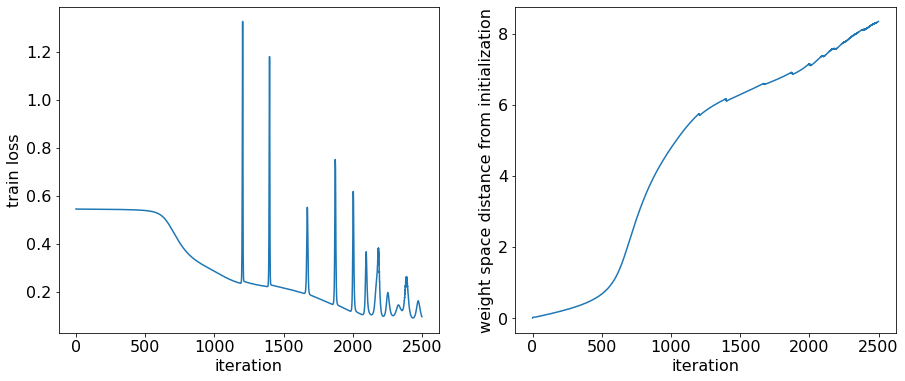

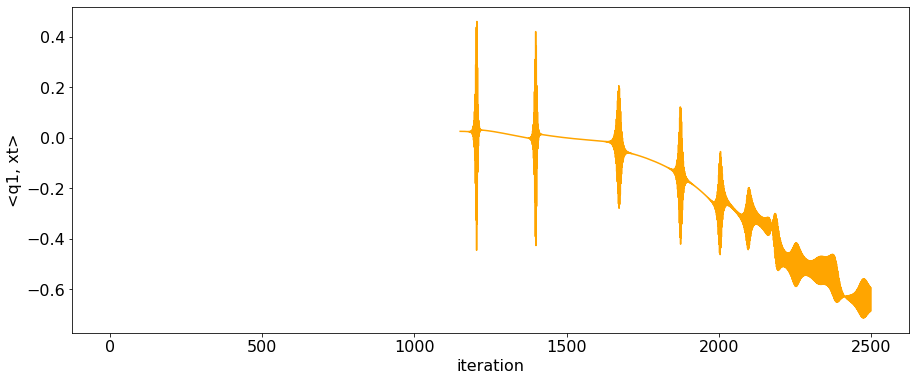

In [ ]:
make_plot(step_size_gd, losses_gd, stats_gd, show_time=False, plot_iterates=True)

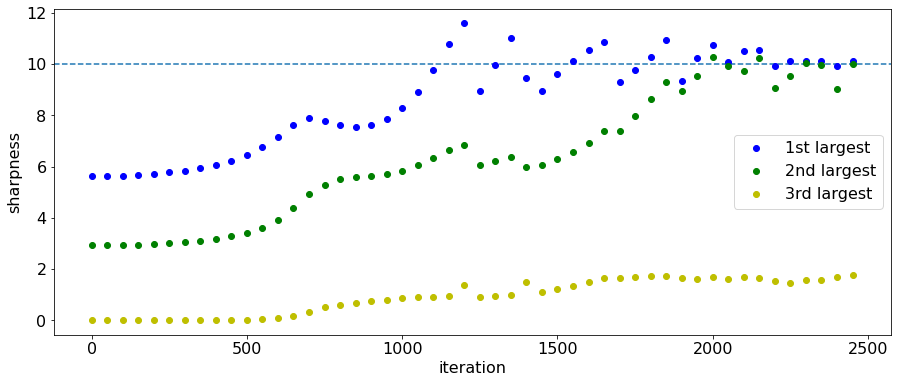

In [ ]:
make_plot(step_size_gd, losses_gd, stats_gd, show_time=False, plot_iterates=False)

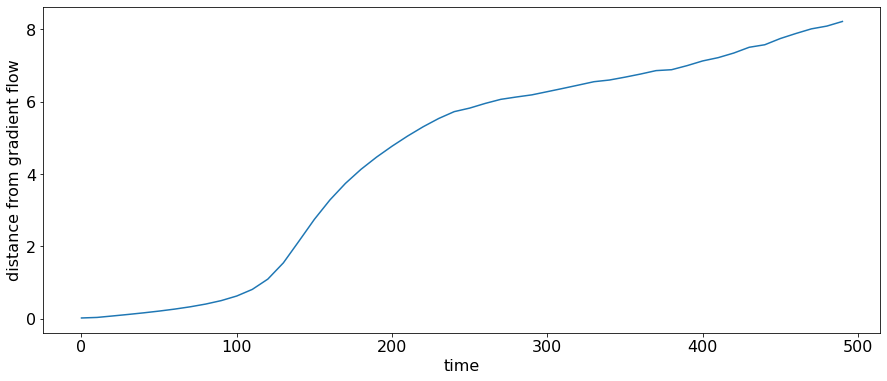

In [ ]:
plot_distance_from_gradient_flow([stats_gd['weights']], [stats_gf['weights']], [log_stats_every_gf])

In [ ]:
r_start = 2050
r_end =  2150
inspection_range = (r_start, r_end)
assert inspection_range[0] >= 0
assert inspection_range[1] > inspection_range[0]
assert inspection_range[1] <= num_epochs_gd
zoom_losses_gd, zoom_stats_gd = train_gd(step_size=step_size_gd, num_epochs=num_epochs_gd, 
                                momentum_mass=momentum_mass,
                                inspection_range=inspection_range)

  0%|          | 0/2500 [00:00<?, ?it/s]

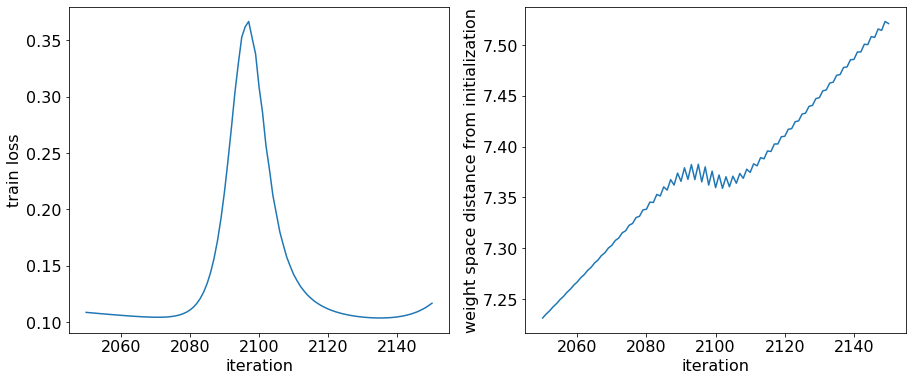

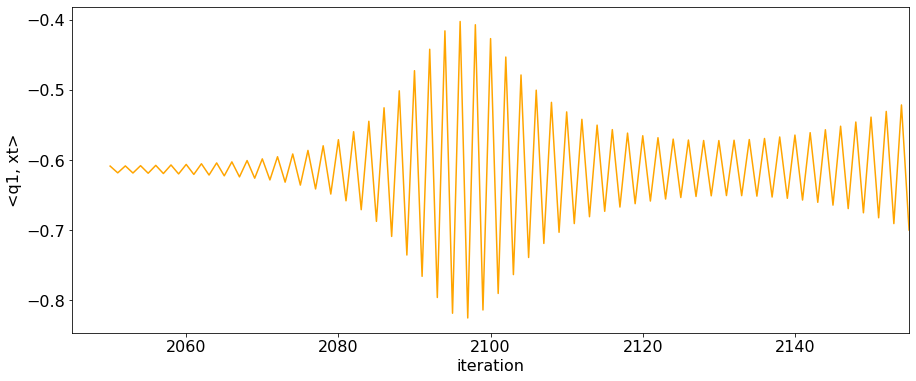

In [ ]:
make_plot(step_size_gd, zoom_losses_gd, zoom_stats_gd, show_time=False, inspection_range=inspection_range, plot_iterates=True)

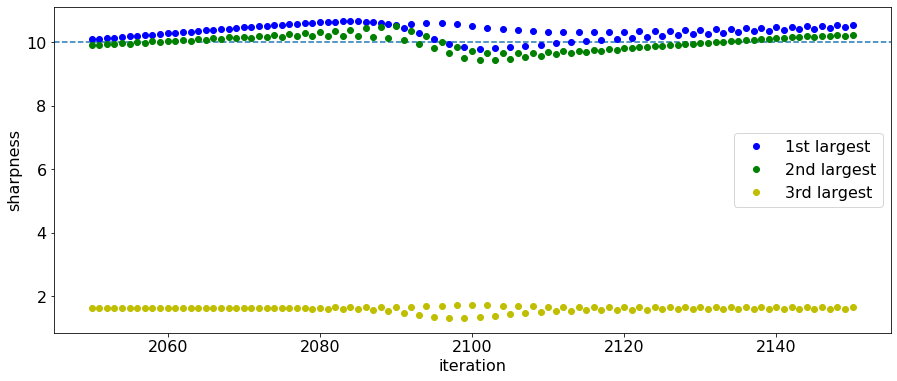

In [ ]:
make_plot(step_size_gd, zoom_losses_gd, zoom_stats_gd, show_time=False, inspection_range=inspection_range, plot_iterates=False)

### Comparing different step sizes

In this section we will see the effect of varying step sizes. The plots should be similar to Figures 85 and 86 in Appendix L.2. Here we run training sessions for 3 different, relatively large, learning rates.

In [ ]:
num_epochs_gd = 3000
log_stats_every_gd = 120
etas = []
all_results_large_lr_gd = []
for i in [6, 8, 10]:
  eta = 2.0 / i
  etas.append(eta)
  train_results = train_gd(step_size=eta, num_epochs=num_epochs_gd, log_stats_every=log_stats_every_gd)
  all_results_large_lr_gd.append(train_results)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
etas = []
all_results_large_lr_gf = []
all_log_stats_every_gf = []
for i in [6, 8, 10]:
  eta = 2.0 / i
  etas.append(eta)
  num_time_gf = int(num_epochs_gd * eta)
  log_stats_every_gf = int(log_stats_every_gd * eta)
  train_results = train_gf(num_time=num_time_gf, log_stats_every=log_stats_every_gf)
  all_log_stats_every_gf.append(log_stats_every_gf)
  all_results_large_lr_gf.append(train_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Now we'll compare the different learning rates within a single plot. The x-axis is "time", which was defined as $\eta \times iteration$. This makes it easier to see similarities in trajectories.

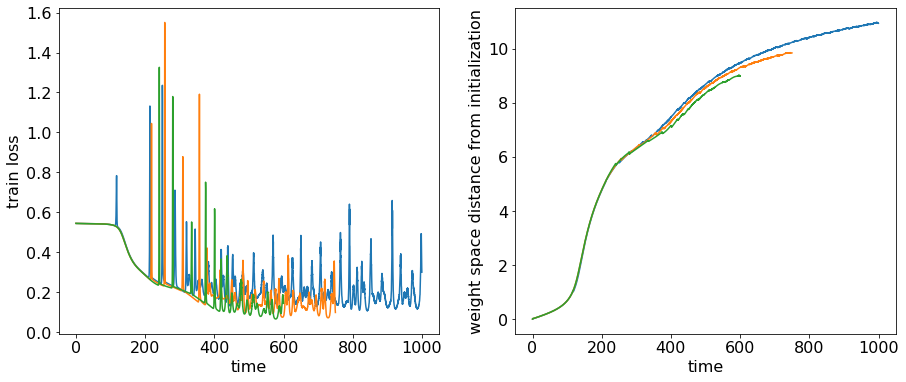

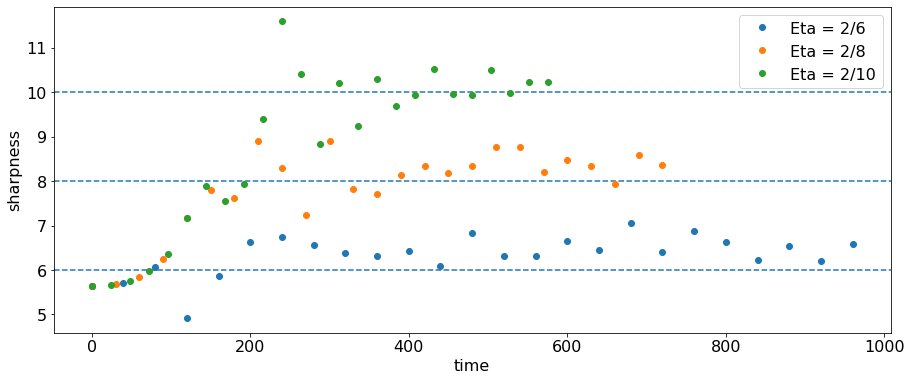

In [ ]:
# rearrange the results
all_losses = []
all_stats = []
for res in all_results_large_lr_gd:
    l, e = res
    all_losses.append(l)
    all_stats.append(e)

make_etas_plot(etas, all_losses, all_stats, True)

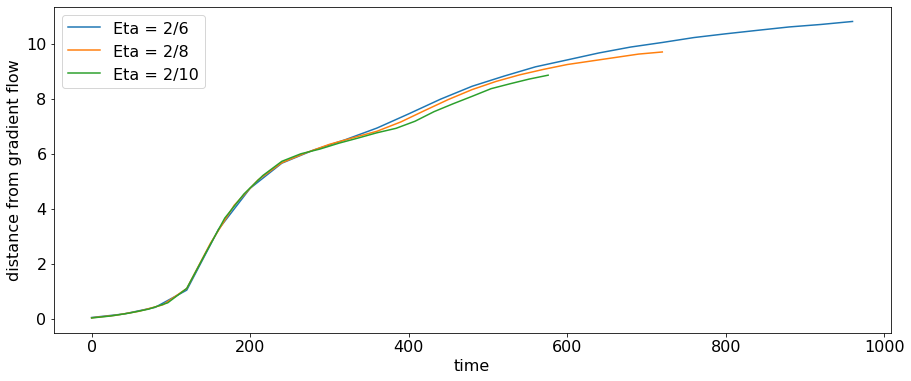

In [ ]:
# rearrange the results
all_weights_gd = []
all_weights_gf = []
for i in range(len(all_results_large_lr_gd)):
    weights_gd = all_results_large_lr_gd[i][1]['weights']
    weights_gf = all_results_large_lr_gf[i][1]['weights']
    
    all_weights_gd.append(weights_gd)
    all_weights_gf.append(weights_gf)


plot_distance_from_gradient_flow(all_weights_gd, all_weights_gf, all_log_stats_every_gf, etas)

To get "smoother" plots we can try smaller step sizes, although this does take a very long time to run.

In [ ]:
num_epochs_gd = 120000
log_stats_every_gd = 1200
etas = []
all_results_small_lr_gd = []

for i in [25, 50, 75]:
  eta = 2.0 / i
  etas.append(eta)
  train_results = train_gd(step_size=eta, num_epochs=num_epochs_gd, log_stats_every=log_stats_every_gd)
  all_results_small_lr_gd.append(train_results)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
etas = []
all_results_small_lr_gf = []
all_log_stats_every_gf = []
for i in [25, 50, 75]:
  eta = 2.0 / i
  etas.append(eta)
  num_time_gf = int(num_epochs_gd * eta)
  log_stats_every_gf = int(log_stats_every_gd * eta)
  train_results = train_gf(num_time=num_time_gf, log_stats_every=log_stats_every_gf)
  all_log_stats_every_gf.append(log_stats_every_gf)
  all_results_small_lr_gf.append(train_results)

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

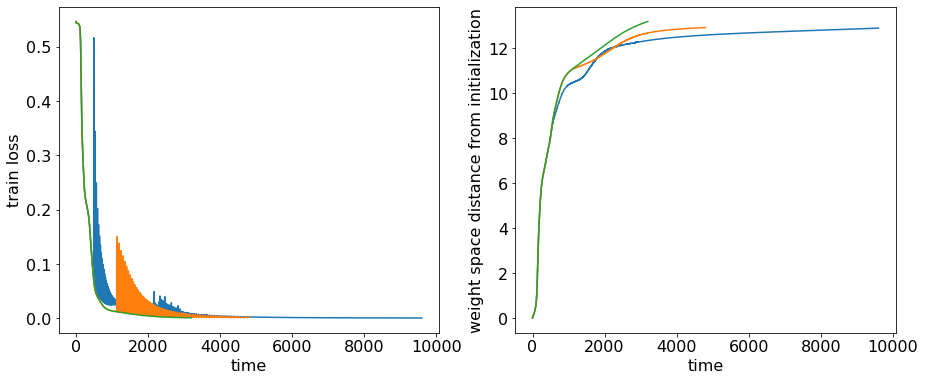

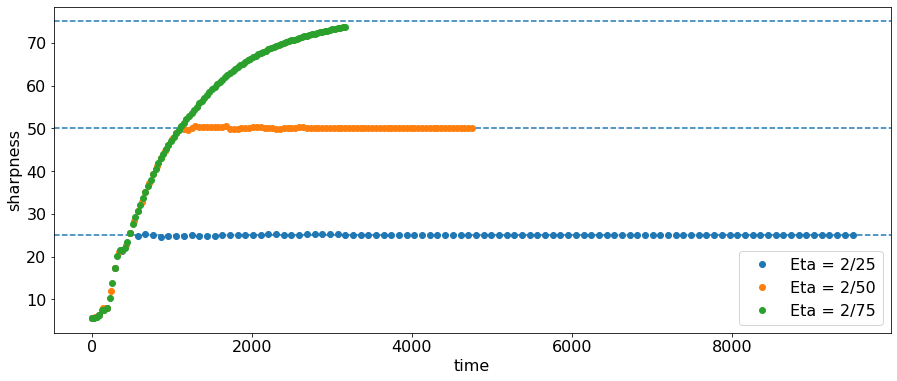

In [ ]:
all_losses = []
all_stats = []
for res in all_results_small_lr_gd:
  l, e = res
  all_losses.append(l)
  all_stats.append(e)

make_etas_plot(etas, all_losses, all_stats, True)

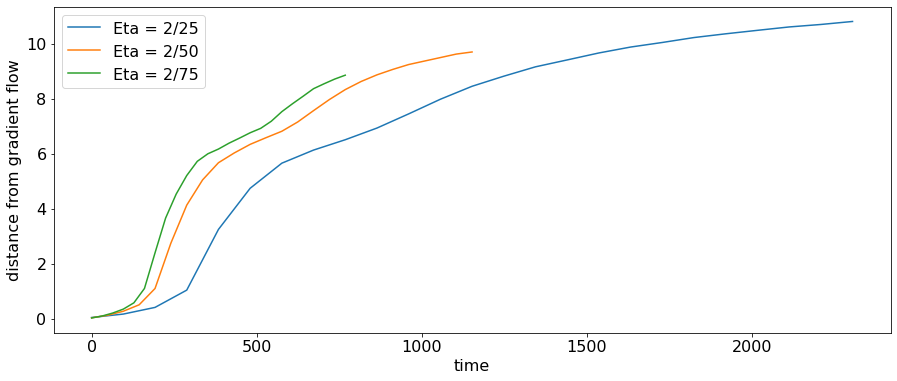

In [ ]:
# rearrange the results
all_weights_gd = []
all_weights_gf = []
for i in range(len(all_results_large_lr_gd)):
    weights_gd = all_results_large_lr_gd[i][1]['weights']
    weights_gf = all_results_large_lr_gf[i][1]['weights']
    
    all_weights_gd.append(weights_gd)
    all_weights_gf.append(weights_gf)

plot_distance_from_gradient_flow(all_weights_gd, all_weights_gf, all_log_stats_every_gf, etas)